In [27]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code/data')
sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code')
import nas_moe.vae
import nas_moe.dataset
import nas_moe.surrogate
import nas_moe.single_arch
import nas_moe.graph
import nas_moe.utils
import os
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
from nni.nas.hub.pytorch import DARTS as DartsSpace
from torch_geometric.utils import dense_to_sparse
import random

SEED = 322
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
train_dataset = torchvision.datasets.CIFAR10(
    root='/pbabkin/main/mipt/nas-for-moe/code/data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

split_valid = int(10000)
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.seed(42)
np.random.shuffle(indices)
valid_subset = Subset(train_dataset, indices[split_valid:])
valid_labels = [label for im, label in valid_subset]

Files already downloaded and verified


In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = nas_moe.vae.VAE(latent_dim=128, channel_num=3)
# trainer = nas_moe.vae.VAETrainer(model, device, lr=3e-4, weight_decay=1e-5)
model2 = nas_moe.vae.VAEv2(
    input_channels=3,
    input_size=32,
    filter_sizes=[32, 64, 128],
    latent_dim=64,
    kernel_size=3,
    stride=2,
    padding=1,
    is_variational=True 
)

trainer = nas_moe.vae.VAETrainer(model2, device, lr=2e-4, weight_decay=1e-5)
trainer.load_checkpoint('/pbabkin/main/mipt/nas-for-moe/vae_checkpoint_anton_1.pth')

/pbabkin/main/mipt/nas-for-moe/code/nas_moe/vae.py:521: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)


In [30]:
# Подготовка данных
images = []
labels = []

for img, label in valid_subset:
    if True:
        z = trainer.encode_image(img)  # Получаем латентный вектор (тензор)
        images.append(z.cpu().numpy())  # Переводим в numpy
    else:
        img_array = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        img_flat = img_array.flatten()
        images.append(img_flat)

    labels.append(label)

X = np.array(images)
y = np.array(labels)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Форма данных: {X.shape}")
# 3072 - просто

Форма данных: (40000, 64)


In [31]:
N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=20, verbose=0)
kmeans.fit(X_scaled)

clusters = kmeans.labels_

# Define and Train

In [43]:
base_path = Path('/pbabkin/main/mipt/nas-for-moe/code/data/CIFAR10_acc/trained_models_archs_1')
# base_path = Path('/pbabkin/main/mipt/nas-for-moe/code/data/CIFAR10_div/CIFAR10_div/architectures')
model_dicts_paths = [base_path / p for p in os.listdir(base_path)]

random.shuffle(model_dicts_paths)

split = int(0.8 * len(model_dicts_paths))

dataset_cluster_acc_train_list = []
dataset_cluster_acc_test_list = []
dataloader_cluster_acc_train_list = []
dataloader_cluster_acc_test_list = []


for k in range(N_CLUSTERS):
    dataset_cluster_acc_train_list.append(nas_moe.dataset.ArchClusterACCDataset(
        model_dicts_paths[:split], 
        clusters,
        valid_labels,
        target_cluster=k
    ))

    dataset_cluster_acc_test_list.append(nas_moe.dataset.ArchClusterACCDataset(
        model_dicts_paths[split:], 
        clusters,
        valid_labels,
        target_cluster=k
    ))

    def collate_graphs(batch):
        return Batch.from_data_list(batch)

    dataloader_cluster_acc_train_list.append(DataLoader(
        dataset_cluster_acc_train_list[-1],
        batch_size=32,
        shuffle=True,
        collate_fn=collate_graphs
    ))

    dataloader_cluster_acc_test_list.append(DataLoader(
        dataset_cluster_acc_test_list[-1],
        batch_size=32,
        shuffle=False,
        collate_fn=collate_graphs
    ))

In [44]:
cluster_baselines = []
for k in range(N_CLUSTERS):
    targets = []
    for el in dataset_cluster_acc_train_list[k]:
        targets.append(el.y)
    targets = torch.tensor(targets)
    mean_targets_train = targets.mean()    # Mean по всем примерам → [10]

    print(f"Mean acc on cluster {k}: {mean_targets_train}")
    cluster_baselines.append(mean_targets_train)

    targets_test = []
    for el in dataset_cluster_acc_test_list[k]:
        targets_test.append(el.y)
    targets_test = torch.tensor(targets_test)
    # print(targets_test)

    print(f"Baseline MSE for cluster {k} = ", ((targets_test - mean_targets_train)**2).mean().item())

Mean acc on cluster 0: 0.789339005947113
Baseline MSE for cluster 0 =  5.299628173816018e-05
Mean acc on cluster 1: 0.7463209629058838
Baseline MSE for cluster 1 =  5.8725487178890035e-05
Mean acc on cluster 2: 0.7337318658828735
Baseline MSE for cluster 2 =  5.109764606459066e-05
Mean acc on cluster 3: 0.7596510052680969
Baseline MSE for cluster 3 =  5.808512287330814e-05


In [35]:
surr_list = []
for k in range(N_CLUSTERS):
    surr_list.append(nas_moe.surrogate.GAT(8, 1))

Training surrogate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [16:33<00:00,  4.97s/it]


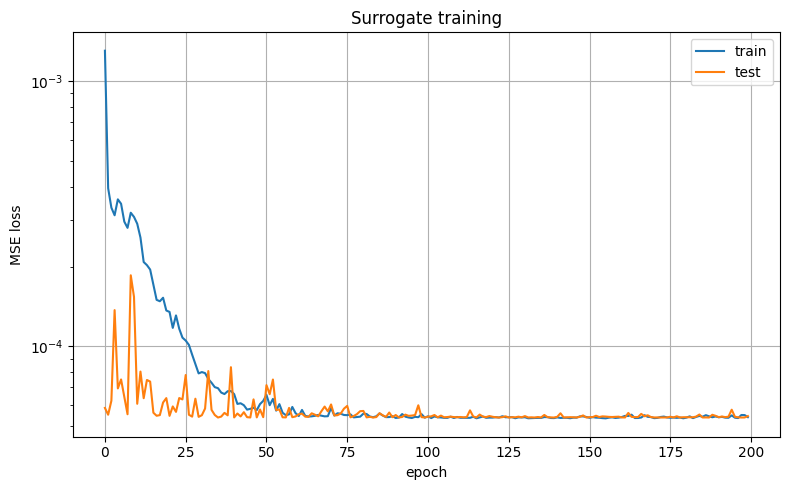

Final train loss for cluster 0 5.409744335338473e-05
Final test loss for cluster 0 5.459396509520177e-05


Training surrogate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [15:37<00:00,  4.69s/it]


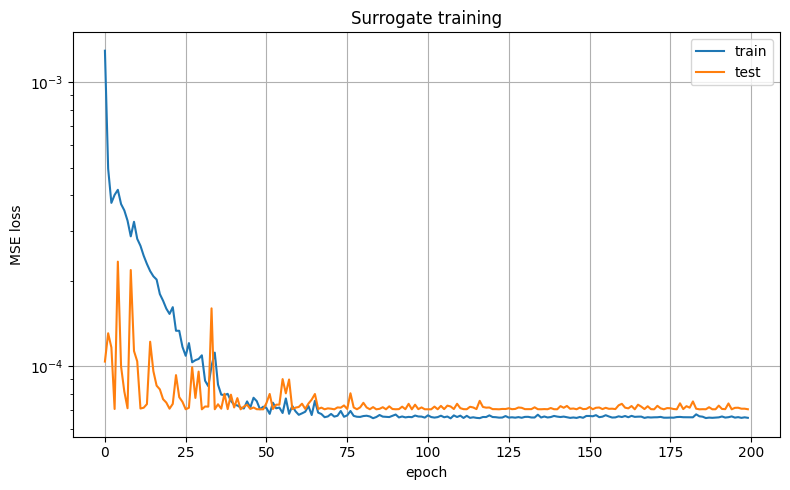

Final train loss for cluster 1 6.582952220924199e-05
Final test loss for cluster 1 7.056475442368537e-05


Training surrogate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [16:15<00:00,  4.88s/it]


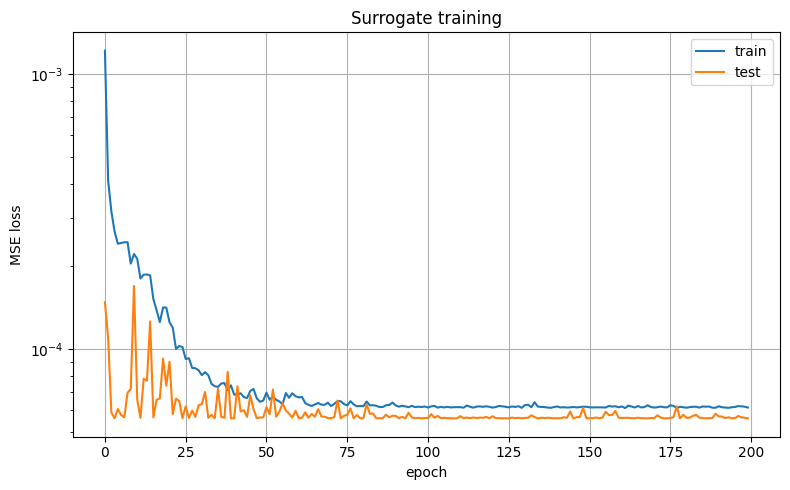

Final train loss for cluster 2 6.128442648332566e-05
Final test loss for cluster 2 5.597866454211596e-05


Training surrogate:  27%|██████████████████████████▏                                                                      | 54/200 [04:33<12:20,  5.07s/it]


KeyboardInterrupt: 

In [37]:
for k in range(N_CLUSTERS):
    surr_list[k].to(device)

    history = nas_moe.utils.train_surrogate_with_val(
        surr_list[k],
        train_loader=dataloader_cluster_acc_train_list[k],
        test_loader=dataloader_cluster_acc_test_list[k],
        device=device, epochs=200,
        lr=0.001, weight_decay=1e-5
    )
    print(f'Final train loss for cluster {k}', history['train'][-1])
    print(f'Final test loss for cluster {k}', history['test'][-1])

# Inference

In [28]:
model_space = DartsSpace(
    width=16,
    num_cells=3,
    dataset='cifar'
)

In [ ]:
arch_dicts = []
archGenerator = nas_moe.single_arch.ParamFilteredArchitectureGenerator(model_space, 8, SEED, threshold=0.7)
# arch_dicts += [archGenerator.generate_arch()['architecture'] for _ in range(10000)]
arch_dicts += [archGenerator.generate_arch_filtered()['architecture'] for _ in range(100000)]

Mean parameters count =  39169.4784
Max parameters count =  27732.1856


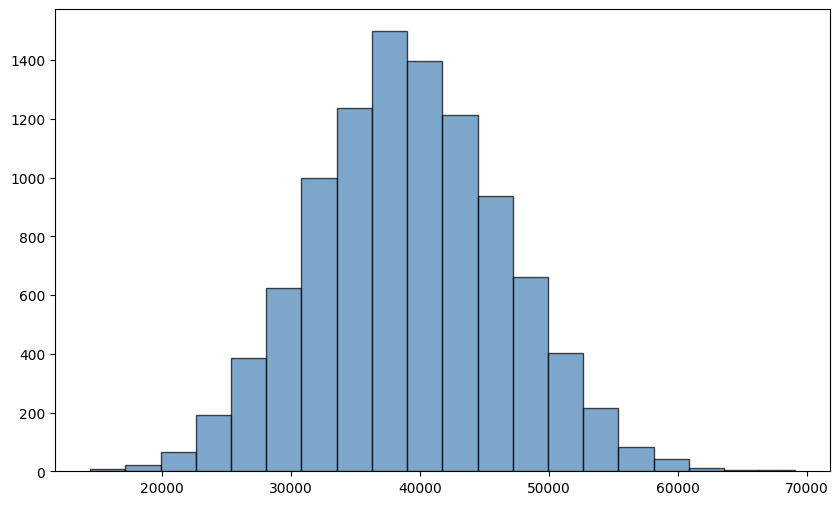

In [30]:
arch_parameters = []
for a in arch_dicts:
    arch_parameters.append(archGenerator.count_params(a))
print('Mean parameters count = ', sum(arch_parameters) / len(arch_dicts))
print('Max parameters count = ', archGenerator.threshold)
plt.figure(figsize=(10, 6))
plt.hist(arch_parameters, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.show()

In [31]:
surr.cpu()

def inference_surr(arch):
    graph = nas_moe.graph.Graph(arch, index=0)
    adj, _, features = graph.get_adjacency_matrix()
    
    features = torch.tensor(features, dtype=torch.float)
    adj = torch.tensor(adj, dtype=torch.float)
    
    edge_index, _ = dense_to_sparse(adj)
    
    batch = torch.zeros(features.size(0), dtype=torch.long)
    
    with torch.no_grad():
        output = surr(features, edge_index, batch)
    return output.squeeze(0)

In [32]:
cluster_accs = [inference_surr(arch) for arch in tqdm(arch_dicts)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 140.41it/s]


In [ ]:
stacked = torch.stack(cluster_accs)  # shape (5, 10)

topk_values, topk_indices = torch.topk(stacked, k=3, dim=0)

max_indices = topk_indices[0]

print("max indices:", max_indices)

max indices: tensor([5855, 2917, 8386, 1846, 1461,  836, 2954, 1846, 5855, 1846])


In [33]:
stacked = torch.stack(cluster_accs)  # shape (5, 10)
max_indices = torch.argmax(stacked, dim=0)  # shape (10,)
print("Max indices:", max_indices)
print("Unique indices:", np.unique(max_indices))
print(len(max_indices), len(np.unique(max_indices)))

Max indices: tensor([9205, 8754, 1565, 6391, 7333])
Unique indices: [1565 6391 7333 8754 9205]
5 5


In [34]:
for i in np.unique(max_indices):
    print(archGenerator.count_params(arch_dicts[i]))

53248
62368
64736
59776
66304


In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.insert(0, '/pbabkin/nas-for-moe/code')
from pathlib import Path

In [2]:
import nas_moe.graph
import os
import json

In [3]:
folder_path = Path('./data/CIFAR10_acc/trained_models_archs_1')
json_paths = [Path(x) for x in os.listdir(folder_path)]

In [4]:
valid_predictions_list = []
valid_acc_list = []
architecture_list = []

for json_path in json_paths:
    with open(folder_path / json_path, 'r') as file:
        data = json.load(file)

    valid_predictions_list += [data['valid_predictions']]
    valid_acc_list += [data['valid_accuracy']]
    architecture_list.append(data['architecture'])
        
    file_path = Path("data.json")

In [10]:
graph = nas_moe.graph.Graph(architecture_list[0])

In [12]:
adj_matrix, operations, one_hot_ops = graph.get_adjacency_matrix()

In [17]:
adj_matrix.shape

(21, 21)

In [19]:
import nas_moe.dataset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
dataset_cluster_acc = nas_moe.dataset.ArchClusterACCDataset(
    './data/CIFAR10_acc/trained_models_archs_1', 

)

nas_moe.dataset.ArchClusterACCDataset